In [264]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

import statistics
import string
import math

import itertools
from collections import defaultdict

import heapq

## 1 Part I :

### 1.1 Getting statistics:

------------------------------------------------------------------------------------------------------------------
1. What is the mean, median, and mode of the data? Comment on the data’s modality (i.e., bimodal, trimodal, etc.).
------------------------------------------------------------------------------------------------------------------
Mean: 29.962962962962962
Median: 25.0
Mode: [25, 35]

Seeing that the calculation of the arrays mode returns 2 unique values (25,35) we can conclude that the data is bimodal.
------------------------------------------------------------------------------------------------------------------
2. Give the five-number summary and the interquartile range (IQR) of the age data.
------------------------------------------------------------------------------------------------------------------
Five-Number Summary:
--------------------
Min:  13
Q1:  20.5
Q2:  25.0
Q3:  35.0
Max:  70
--------------------
Interquartile Range:
--------------------
IQR:  14.5
---

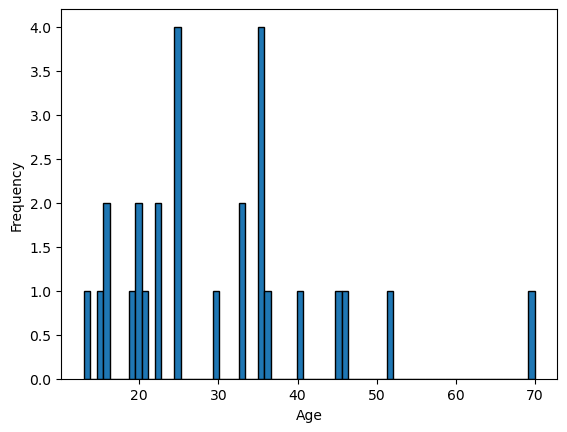

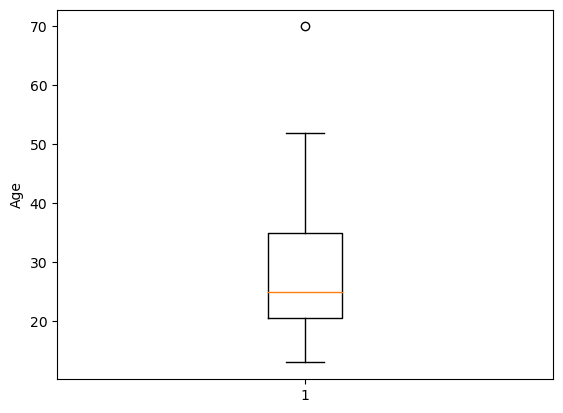

In [265]:
print("------------------------------------------------------------------------------------------------------------------")
print("1. What is the mean, median, and mode of the data? Comment on the data’s modality (i.e., bimodal, trimodal, etc.).")
print("------------------------------------------------------------------------------------------------------------------")

#list of ages
age_array = np.array([13, 15, 16, 16, 19, 20, 20, 21, 22, 22, 25, 25, 25, 25, 30, 33, 33, 35, 35, 35, 35, 36, 40, 45, 46, 52, 70])

mean = age_array.mean()
median = np.median(age_array, axis=None)
mode = statistics.multimode(age_array)

print("Mean:", mean)
print("Median:", median)
print("Mode:", mode)

print("\nSeeing that the calculation of the arrays mode returns 2 unique values (25,35) we can conclude that the data is bimodal.")

print("------------------------------------------------------------------------------------------------------------------")
print("2. Give the five-number summary and the interquartile range (IQR) of the age data.")
print("------------------------------------------------------------------------------------------------------------------")

#five number summary is made up of 5 quartiles -> min, max, upper and lower quartiles, and the median
age_min = age_array.min() #q1
age_max = age_array.max() #q2

age_df = pd.DataFrame(data = age_array)#use pandas built in percentile method for upper and lower quartiles
Q1 = np.percentile(age_df, 25)#lower quartile
Q2 = median #average
Q3 = np.percentile(age_df, 75)#upper quartile

#"interquartile range tells you the spread of the middle half of your distribution"
IQR = Q3 - Q1

#display results
print("Five-Number Summary:")
print("--------------------")
print("Min: ", age_min)
print("Q1: ", Q1)
print("Q2: ", Q2)
print("Q3: ", Q3)
print("Max: ", age_max)

print("--------------------")
print("Interquartile Range:")
print("--------------------")
print("IQR: ", IQR)

print("------------------------------------------------------------------------------------------------------------------")
print("3. Show the histogram and boxplot of the data.")
print("------------------------------------------------------------------------------------------------------------------")

#create histogram
plt.hist(age_array, bins=age_max, edgecolor = "black")#made bins to max age to show maximum plots
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()
#create boxplot
plt.boxplot(age_array)
plt.ylabel('Age')
plt.show()

### 1.2 Document Similarity:

In [266]:
#Step 1
#======================================================================
def create_shingles(docArray):
    #Description: Given a document, split it into individual words/shingles
    #Parameters: docArray (list[String]) a list of strings to split into shingles
    #Returns: shingleDocs (List[List[String]]) 2d list of individual strings/shingles from input
    shingleDocs = []

    for doc in docArray:
        #remove punctuation, put into lowercase, and split up words
        shingleDocs.append(set(doc.translate(str.maketrans('', '', string.punctuation)).lower().split()))
    
    return shingleDocs

#Step 2 - minhash to aproximate jaccard sim
#======================================================================      

def hash_function(shingle, i):
    #Description: set hash function from assignment to apply on shingles and convert to hash value
    #Parameters: 
    #shingle (String): string to convert to hash value, 
    #i (int): position of signature array size maxnumber of hashes
    #Returns: hashed value for shingle
    return ((123 * (hash(shingle)) * i) + 456) % 9999991


def minhash_signature(shingles, hashes):
    #Description: set hash function from assignment to apply on shingles and convert to hash value
    #Parameters: 
    #shingles (list[string]): list of strings to , 
    #i (int): position of signature array size maxnumber of hashes
    #Returns: signature_array (list[int]) list of hashed values for shingles
    signature_array = [math.inf] * hashes #create array of initial max values to compare for min values
    for i in range(hashes): #for every hash in max hashes
        for shingle in shingles: #loop through shingles  and take smallest hash
            hashval = hash_function(shingle,i)
            if hashval < signature_array[i]: signature_array[i] = hashval
    
            
    return signature_array

def jaccard_calc(signatures, hashes):
    #Description: prints the jaccard aproximation
    #Parameters: 
    #signatures (list[int] , hashed shingle values
    #hashes (int): max number of hashes
    #Returns: none
    size = len(signatures)#iterate through size of hash signature list
    for i in range(size):
        for j in range(i+1,size):#dont use same signature
            set1 = set(signatures[i])
            set2 = set(signatures[j])

            
            aprox = len(set1.intersection(set2)) / len(set1.union(set2))#formula from lecture |intersection|/|union|
            print(f"[D{i+1},D{j+1}]: {aprox}")
            
def jaccard_aprox(shingleDocs, hashes):
    #Description: call appropriate functions to print an aproximate jaccard similarity using minhash
    #Parameters: 
    #shingleDocs (list[list[string]]): list of shingles , 
    #hashes (int): max number of hashes
    #Returns: minhash signatures to use for step 3
    signatures = []
    for shingles in shingleDocs:
        signatures.append(minhash_signature(shingles,hashes))#create minhash signatures

    jaccard_calc(signatures, hashes)#call function to print aproximation
    return signatures
    
#Step 3
#======================================================================
def lsh(signature_array, bands=16, rows=8):
    buckets = [[] for _ in range(bands)]  
    pairs = set()

    for band in range(bands):
        for i, signature in enumerate(signature_array):
            new_signature = tuple(signature[band * rows: (band + 1) * rows])
            bucket = hash_function(new_signature, band)#i couldnt figure out how to use this properly :(

            for item in buckets[band]:
                pairs.add(tuple(sorted((i, item))))

            buckets[band].append(i)

    return pairs

#Step 4
#======================================================================
def jaccard_sim(candidate_pairs, shingleDocs, threshold):
    similar_pairs = []
    for i, j in candidate_pairs:
        x = shingleDocs[i]
        y = shingleDocs[j]
        value = len(x.intersection(y))/len(x.union(y))#formula from lecture
        if value > threshold:
            similar_pairs.append(((i, j), value))
    print(f"Pairs with similarity above {threshold}:")
    for pair, value in similar_pairs:
        x = pair[0] + 1
        y = pair[1] + 1
        print(f"[D{x},D{y}]: {value}")

#########################################################################################################

def docSim(docArray, threshold, hashes=128):
        
    print("====================================================================================")
    print("1. Convert the documents into sets of words (Shingles)")
    print("====================================================================================")
    shingleDocs = create_shingles(docArray)   
        
    for i in range(len(shingleDocs)):
        print(f"D{i+1}: {shingleDocs[i]}")
        
    print("====================================================================================")
    print("2. Use MinHash to approximate the Jaccard similarity of the document pairs.Set the")
    print("number of hashes as 128 and the hash function as h = (123 × x + 456)%9999991")
    print("====================================================================================")
    
    signature_array = jaccard_aprox(shingleDocs, hashes)
    
    print("====================================================================================")
    print("3. Use LSH to find candidate pairs that are potentially similar. Set the number of ")
    print("bands as 16, and the number of rows per band as 8")
    print("====================================================================================")
    
    candidate_pairs = lsh(signature_array,16,8)
    print(candidate_pairs)
    
    print("====================================================================================")
    print("4. Compute the Jaccard similarity for the candidate pairs and output pairs that have")
    print("similarity above a threshold bands as 16, and the number of rows per band as 8")
    print("====================================================================================")
    
    jaccard_sim(candidate_pairs, shingleDocs, threshold)

In [267]:
print("Part 1: Threshold > 0.3")

D1 = "Locality sensitive hashing is very useful for large scale applications."
D2 = "LSH is useful for large scale data processing and similarity detection."
D3 = "Hashing techniques are prevalent in large data processing."
D4 = "Locality hashing helps in efficient large scale computations."

docArray = [D1,D2,D3,D4]

threshold = 0.3

x = docSim(docArray,threshold)

Part 1: Threshold > 0.3
1. Convert the documents into sets of words (Shingles)
D1: {'hashing', 'is', 'useful', 'scale', 'for', 'very', 'large', 'applications', 'locality', 'sensitive'}
D2: {'data', 'detection', 'is', 'useful', 'scale', 'for', 'large', 'and', 'lsh', 'processing', 'similarity'}
D3: {'hashing', 'data', 'are', 'large', 'prevalent', 'in', 'processing', 'techniques'}
D4: {'hashing', 'scale', 'large', 'computations', 'in', 'locality', 'efficient', 'helps'}
2. Use MinHash to approximate the Jaccard similarity of the document pairs.Set the
number of hashes as 128 and the hash function as h = (123 × x + 456)%9999991
[D1,D2]: 0.1743119266055046
[D1,D3]: 0.0847457627118644
[D1,D4]: 0.1583710407239819
[D2,D3]: 0.09871244635193133
[D2,D4]: 0.04918032786885246
[D3,D4]: 0.16363636363636364
3. Use LSH to find candidate pairs that are potentially similar. Set the number of 
bands as 16, and the number of rows per band as 8
{(0, 1), (1, 2), (0, 3), (2, 3), (0, 2), (1, 3)}
4. Compute the 

In [268]:
print("Part 2: Threshold > 0.5")

D1 = "Locality sensitive hashing is useful."
D2 = "Locality sensitive hashing is beneficial."
D3 = "Locality sensitive techniques are useful."
D4 = "Locality hashing is extremely useful"

docArray = [D1,D2,D3,D4]

threshold = 0.5

x = docSim(docArray,threshold)

Part 2: Threshold > 0.5
1. Convert the documents into sets of words (Shingles)
D1: {'hashing', 'is', 'useful', 'locality', 'sensitive'}
D2: {'hashing', 'is', 'beneficial', 'locality', 'sensitive'}
D3: {'techniques', 'useful', 'are', 'locality', 'sensitive'}
D4: {'hashing', 'is', 'useful', 'extremely', 'locality'}
2. Use MinHash to approximate the Jaccard similarity of the document pairs.Set the
number of hashes as 128 and the hash function as h = (123 × x + 456)%9999991
[D1,D2]: 0.47126436781609193
[D1,D3]: 0.20754716981132076
[D1,D4]: 0.46285714285714286
[D2,D3]: 0.09871244635193133
[D2,D4]: 0.24878048780487805
[D3,D4]: 0.09401709401709402
3. Use LSH to find candidate pairs that are potentially similar. Set the number of 
bands as 16, and the number of rows per band as 8
{(0, 1), (1, 2), (0, 3), (2, 3), (0, 2), (1, 3)}
4. Compute the Jaccard similarity for the candidate pairs and output pairs that have
similarity above a threshold bands as 16, and the number of rows per band as 8
Pair

## 2 Cross-selling recommendation with Apriori:

In [291]:
def importSessions(file):
    #read file and put sessions into sets
    with open(file, 'r') as f:
        sessions = [set(line.strip().split()) for line in f] 
    return sessions

def frequent_singles(values, minS):
    freq_singles = {} 
    minSVals = {}
    for line in values:
        for session in line:
            if session in freq_singles:
                freq_singles[session] += 1
                if freq_singles[session] >= minS:
                    minSVals[session] = freq_singles[session]
            else:
                freq_singles[session] = 1
                
    for single in freq_singles:
        freq = freq_singles[single]
        if freq >= minS:
            minSVals[single] = freq

    return minSVals


def frequent_x(x_sessions, sessions, frequent_items, min_support):
    #used for frequent pairs and triples where x_sessions = 2 is pairts 3 is triples
    #logic follows the same as frequent_singles
    freq_x = defaultdict(int)#this made it easier than creaing a new dictionary shoutout chand man for the tip
    min_supp_x = {} #sets that meet min support
    freq_possible = set(itertools.combinations(frequent_items, x_sessions))#create all possible combos again shout out chan man
    #go through every line 
    for line in sessions:
        line_possible = itertools.combinations(line, x_sessions) #only check if it contains frequent singles (apriori)
        for x in line_possible:
            if x in freq_possible: #if its a possible combo using frequent singletons add to count
                if x in freq_x:
                    freq_x[x] += 1
                    if freq_x[x] >= min_support: #if count meets min support track it
                        min_supp_x[x] = freq_x[x]
                else: freq_x[x] = 1

    return min_supp_x


def pair_rules(doubles, singles):
    #determine association rules and retun top 5
    rules = [] #all rules
    toprules = []#sorted top 5 rules using heap

    for pair in doubles:#for every frequent pair
        count = doubles[pair] #get its count
        for session in pair:#for every session in pair
            if session in singles:#if frequent single
                conf = count/singles[session]#calc confidence -> see lecture formula
                rules.append([pair, conf])#add pair and confidence value
                heapq.heappush(toprules, (-conf,list(pair)))#add to heap, we use negative value to sort
                if len(toprules) > 5:#if heap is greater than 5 remove 
                    heapq.heappop(toprules)
                    
    top5 = [(rule, -conf) for conf, rule in toprules]#create tuple of top 5

    return rules, top5

def triple_rules(triples, doubles, singles):
    #same logic as double rules
    rules = []
    toprules = []
    
    for throuple in triples:
        count3 = triples[throuple]
        combos = itertools.combinations(throuple, 2)
        for pair in combos:
                if pair in doubles:
                    conf = count3/doubles[pair]
                    new_rule = list(pair)
                    set_extract_tuple = set(next(iter(triple)))
                    new_rule.append((set_extract_tuple - set(pair)).pop())
                    rules.append([new_rule, conf])
                    heapq.heappush(toprules, (-conf,new_rule))
                    if len(toprules) > 5:
                        heapq.heappop(toprules)
                        
    top5 = [(rule, -conf) for conf, rule in toprules]

    return rules, top5


#########################################################################################################
    
def crossSell(min_support, file="crossselling.txt"):
    sessions = importSessions(file)
    
    singles = frequent_singles(sessions,min_support)
    print(f"(a) Frequent Singletons: {len(singles)}" )
    
    doubles = (frequent_x(2,sessions,singles,min_support))
    print(f"(b) Frequent Pairs: {len(doubles)}" )
    
    triples = (frequent_x(3,sessions,singles,min_support))
    print(f"(c) Frequent Triples: {len(triples)}" )
    
    double_rules, double_top5 = pair_rules(doubles, singles)
    print(f"(d) Rules Generated From Frequent Pairs: {len(double_rules)}")
    
    trip_rules, triple_top5 = triple_rules(triples, doubles, singles)
    print(f"(e) Rules Generated From Frequent Triples: {len(trip_rules)}")
    
    print(f"(f) Top 5 Rules Sorted:")
    
    print("\nPairs:")
    for i in double_top5:
        print(i)
        
    print("\nTriples:")
    for i in triple_top5:
        print(i)
    
    return doubles, triples

In [270]:
print("====================================================================================")
print("2. Set the minimum support s = 100, i.e., product pairs need to occur together at") 
print("least 100 times to be considered frequent")
print("====================================================================================")
min_support = 100
double,triple = crossSell(min_support)

2. Set the minimum support s = 100, i.e., product pairs need to occur together at
least 100 times to be considered frequent
(a) Frequent Singletons: 647
(b) Frequent Pairs: 614
(c) Frequent Triples: 33
(d) Rules Generated From Frequent Pairs: 1228
(e) Rules Generated From Frequent Triples: 99
(f) Top 5 Rules Sorted:

Pairs:
(['DAI62779', 'DAI33336'], 0.015299235038248088)
(['DAI62779', 'ELE60381'], 0.015299235038248088)
(['DAI62779', 'SNA31619'], 0.015149242537873106)
(['DAI62779', 'DAI83948'], 0.014999250037498125)
(['DAI62779', 'GRO29598'], 0.015299235038248088)

Triples:
(['DAI62779', 'DAI75645', 'DAI43223'], 0.11609195402298851)
(['DAI62779', 'DAI85309', 'DAI43223'], 0.11002178649237472)
(['ELE32164', 'GRO59710', 'DAI43223'], 0.11343612334801761)
(['DAI62779', 'FRO40251', 'DAI43223'], 0.10934579439252337)
(['DAI62779', 'FRO40251', 'DAI43223'], 0.09813084112149532)


In [279]:
print("====================================================================================")
print("Identify all pairs of items (X, Y) such that the support of {X, Y} is at least") 
print("100. For all such pairs, compute the confidence scores of the corresponding association")
print("rules: X → Y and Y → X. Sort the rules in decreasing order of confidence scores.")
print("====================================================================================")
print(double)
print("====================================================================================")
print("Identify item triples (X, Y, Z) such that the support of {X, Y, Z} is at least") 
print("100. For all such triples, compute the confidence scores of the corresponding") 
print("association rules: (X, Y ) → Z, (X, Z) → Y , (Y, Z) → X. Sort the rules in decreasing")
print("order of confidence scores")
print("====================================================================================")
print(triple)

Identify all pairs of items (X, Y) such that the support of {X, Y} is at least
100. For all such pairs, compute the confidence scores of the corresponding association
rules: X → Y and Y → X. Sort the rules in decreasing order of confidence scores.
{('DAI62779', 'FRO19221'): 383, ('FRO40251', 'GRO85051'): 537, ('DAI62779', 'FRO40251'): 1070, ('DAI62779', 'SNA80324'): 923, ('DAI62779', 'DAI75645'): 870, ('DAI62779', 'ELE17451'): 823, ('DAI62779', 'SNA55762'): 593, ('ELE32164', 'GRO59710'): 908, ('ELE32164', 'DAI43223'): 710, ('DAI62779', 'DAI85309'): 918, ('DAI62779', 'GRO94758'): 479, ('DAI62779', 'GRO30386'): 709, ('DAI62779', 'SNA45677'): 604, ('DAI62779', 'ELE99737'): 401, ('GRO73461', 'FRO40251'): 577, ('DAI62779', 'GRO71621'): 595, ('ELE17451', 'DAI75645'): 522, ('FRO40251', 'SNA80324'): 488, ('FRO85978', 'SNA95666'): 462, ('DAI62779', 'SNA93860'): 537, ('DAI62779', 'FRO80039'): 550, ('GRO59710', 'DAI43223'): 512, ('DAI62779', 'FRO78087'): 482, ('DAI62779', 'GRO85051'): 378, ('DAI6

In [292]:
print("====================================================================================")
print("2. Set the minimum support s = 250, i.e., product pairs need to occur together at") 
print("least 250 times to be considered frequent")
print("====================================================================================")
min_support = 250
double,triple = crossSell(min_support)

2. Set the minimum support s = 250, i.e., product pairs need to occur together at
least 250 times to be considered frequent
(a) Frequent Singletons: 287
(b) Frequent Pairs: 93
(c) Frequent Triples: 1
(d) Rules Generated From Frequent Pairs: 186
(e) Rules Generated From Frequent Triples: 3
(f) Top 5 Rules Sorted:

Pairs:
(['DAI62779', 'FRO35904'], 0.03914804259787011)
(['DAI62779', 'DAI55911'], 0.03884805759712014)
(['DAI62779', 'DAI31081'], 0.03884805759712014)
(['DAI62779', 'ELE74482'], 0.03809809509524524)
(['DAI62779', 'SNA59903'], 0.03749812509374531)

Triples:
(['GRO59710', 'DAI43223', 'ELE32164'], 0.560546875)
(['ELE32164', 'GRO59710', 'DAI43223'], 0.31607929515418504)
(['ELE32164', 'DAI43223', 'GRO59710'], 0.4042253521126761)


In [273]:
print("====================================================================================")
print("Identify all pairs of items (X, Y) such that the support of {X, Y} is at least") 
print("250. For all such pairs, compute the confidence scores of the corresponding association")
print("rules: X → Y and Y → X. Sort the rules in decreasing order of confidence scores.")
print("====================================================================================")
print(double)
print("====================================================================================")
print("Identify item triples (X, Y, Z) such that the support of {X, Y, Z} is at least") 
print("250. For all such triples, compute the confidence scores of the corresponding") 
print("association rules: (X, Y ) → Z, (X, Z) → Y , (Y, Z) → X. Sort the rules in decreasing")
print("order of confidence scores")
print("====================================================================================")
print(triple)

Identify all pairs of items (X, Y) such that the support of {X, Y} is at least
250. For all such pairs, compute the confidence scores of the corresponding association
rules: X → Y and Y → X. Sort the rules in decreasing order of confidence scores.
{('DAI62779', 'FRO19221'): 383, ('FRO40251', 'GRO85051'): 537, ('DAI62779', 'FRO40251'): 1070, ('DAI62779', 'SNA80324'): 923, ('DAI62779', 'DAI75645'): 870, ('DAI62779', 'ELE17451'): 823, ('DAI62779', 'SNA55762'): 593, ('ELE32164', 'GRO59710'): 908, ('ELE32164', 'DAI43223'): 710, ('DAI62779', 'DAI85309'): 918, ('DAI62779', 'GRO94758'): 479, ('DAI62779', 'GRO30386'): 709, ('DAI62779', 'SNA45677'): 604, ('DAI62779', 'ELE99737'): 401, ('GRO73461', 'FRO40251'): 577, ('DAI62779', 'GRO71621'): 595, ('ELE17451', 'DAI75645'): 522, ('FRO40251', 'SNA80324'): 488, ('FRO85978', 'SNA95666'): 462, ('DAI62779', 'SNA93860'): 537, ('DAI62779', 'FRO80039'): 550, ('GRO59710', 'DAI43223'): 512, ('DAI62779', 'FRO78087'): 482, ('DAI62779', 'GRO85051'): 378, ('DAI6

## Analyze the outcomes of both experiments and describe the insights you’ve gathered in your own language

In case 1 where the minimum support is 100, I see the confidence values are much lower and a larger amount of singletons, pairs and triples are generated. I see that it was succesful in providing the top 5 confidence scores for both pairs and triples. Can also be said that case 1 was much more expensive and thus having a longer runtime.

In case 2 where the minimum support is 250, the program ran much faster! From that it makes sense that less values were generated and less values would result in higher confidence scores. In this case only 3 triples were generated so a top 5 was not possible.

comparing both case 1 and case 2, the first thing I noticed was that the change in support (250/100 = 2.5) aproximately matches the change in confidence levels for their pairs (ex. 0.03914804259787011/0.015299235038248088 = 2.558823529411765)

secondly if we look at the dropoff between the output of singletons, pairs and triples as we increase s:

singletons - 647/287 =  2.254355400696864  //note the number of singletons is also close to 2.5
pairs - 614/93 = 6.602150537634409
triples - 33/1 = 33

I'm unsure if this trend would follow suit for all varieties of data and continuing past triples, however looking at the above it appears the increase of number of singletons to pairs to triples, etc follows the pattern:

f(x) ~= 2.5 for x = 1
f(x) ~=  (x-1)*(2.5)*f(x-1) for x > 1

example:

let x = 3 where 3 shows we are producing triples

f(3) = (3-1)*(2.5) * 6.602150537634409 = 33.011

I also noted there was a larger jump in s = 250 with respect to the difference between confidence levels of pairs and triples.

In conclusion it can be shown that by increasing the minimum support level, we increase the confidence levels and reduce the number of frequent items.



